Reproduce: SimPEG
====================

## Simulating TMI Data Over a Susceptible Block in a Halfspace

Total magnetic intensity (TMI) data are simulated over susceptible block using SimPEG. The background susceptibility is 0.0001 SI and the susceptibility of the block is 0.025 SI. The dimensions of the block in the x, y and z directions are all 200 m. The block is buried at a depth of 200 m.

TMI data are simulated on a regular grid of points for an airborne survey. The receiver height is set to be 30 m above the surface. The station spacing is 50 m in both the X and Y directions.

## SimPEG Package Details

**Link to the docstrings for the simulation.** The docstrings will have a citation and show the integral equation.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from SimPEG import dask
from SimPEG.potential_fields import magnetics
from SimPEG.utils import plot2Ddata
from SimPEG.utils.io_utils import read_mag3d_ubc, write_mag3d_ubc
from SimPEG import maps, data
from discretize import TensorMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({"font.size": 14})
write_output = True

A compressed folder containing the assets required to run the notebook is then downloaded. This includes mesh, model and survey files for the forward simulation.

In [2]:
# Download .tar files

Extracted files are then loaded into the SimPEG framework.

In [3]:
rootdir = './../../../assets/magnetics/block_halfspace_tmi_fwd_simpeg/'
meshfile = rootdir + 'mesh.txt'
modelfile = rootdir + 'model.sus'
locfile = rootdir + 'survey.loc'

mesh = TensorMesh.read_UBC(meshfile)
model = TensorMesh.read_model_UBC(mesh, modelfile)
mag_data = read_mag3d_ubc(locfile)

Below, we plot the model and the survey geometry used in the forward simulation.

Text(0, 0.5, 'y (m)')

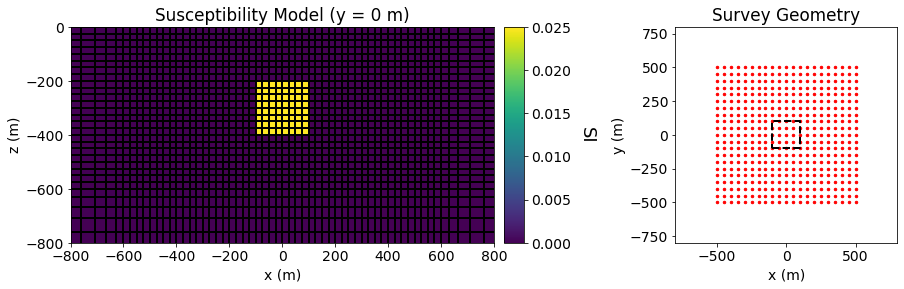

In [4]:
fig = plt.figure(figsize=(14, 4))

ax11 = fig.add_axes([0.1, 0.15, 0.42, 0.75])
ind = int(mesh.shape_cells[1]/2)
mesh.plot_slice(model, normal='Y', ind=ind, grid=True, ax=ax11, pcolor_opts={"cmap": "viridis"})

ax11.set_xlim([-800, 800])
ax11.set_ylim([-800, 0])
ax11.set_title("Susceptibility Model (y = 0 m)")
ax11.set_xlabel("x (m)")
ax11.set_ylabel("z (m)")

ax12 = fig.add_axes([0.53, 0.15, 0.02, 0.75])
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax12, norm=norm, cmap=mpl.cm.viridis, orientation="vertical"
)
cbar.set_label("SI", rotation=270, labelpad=25, size=18)

xyz = mag_data.survey.receiver_locations
ax21 = fig.add_axes([0.7, 0.15, 0.22, 0.75])
ax21.scatter(xyz[:, 0], xyz[:, 1], 6, 'r')
ax21.plot(100*np.r_[-1, 1, 1, -1, -1], 100*np.r_[-1, -1, 1, 1, -1], 'k--', lw=2.)
ax21.set_xlim([-800, 800])
ax21.set_ylim([-800, 800])
ax21.set_title("Survey Geometry")
ax21.set_xlabel("x (m)")
ax21.set_ylabel("y (m)")

Here we define the mapping from the model to the mesh, extract the survey from the data object and define the forward simulation.

In [5]:
chi_map = maps.IdentityMap(nP=mesh.nC)

survey = mag_data.survey

simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    chiMap=chi_map,
    store_sensitivities="forward_only"
)

Finally, we predict the TMI data for the model provided.

In [6]:
dpred_simpeg = simulation.dpred(model)

Forward calculation: 
[########################################] | 100% Completed |  1min  4.9s


If desired, we can export the simulated TMI data to a UBC formatted data file.

In [7]:
if write_output:
    data_simpeg = data.Data(survey=survey, dobs=dpred_simpeg)
    outname = rootdir + 'dpred_simpeg.mag'
    write_mag3d_ubc(outname, data_simpeg)

Observation file saved to: ./../../../assets/magnetics/block_halfspace_tmi_fwd_simpeg/dpred_simpeg.mag


## Simulated TMI Data Plot

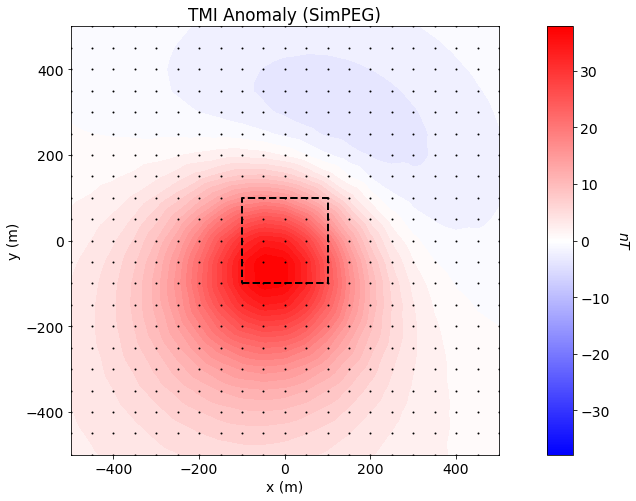

In [8]:
xyz = survey.receiver_locations
max_val = np.max(np.abs(dpred_simpeg))

fig = plt.figure(figsize=(9, 7))

ax1 = fig.add_axes([0.05, 0.1, 0.85, 0.85])
plot2Ddata(
    xyz, dpred_simpeg, ax=ax1, clim=(-max_val, max_val),
    dataloc=True, ncontour=50, contourOpts={"cmap": "bwr"}
)
ax1.plot(100*np.r_[-1, 1, 1, -1, -1], 100*np.r_[-1, -1, 1, 1, -1], 'k--', lw=2.)
ax1.set_title("TMI Anomaly (SimPEG)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.88, 0.1, 0.04, 0.85])
norm = mpl.colors.Normalize(vmin=-max_val, vmax=max_val)
cbar2 = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar2.set_label("$nT$", rotation=270, labelpad=20, size=14)

plt.show()